#Slide extraction in the presence of video compression artifacts
## Author: Phillip Nordwall

I had a video of a presentation that had artifacts from over compression. As I wanted to see what the slides said I thought it might be possible to average out the artifacts. The following is an exploration of using an Ipython notebook to do so.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('dJlHBS7sP_c',width=640, height=480)

# Requirements

## python

* Ipython notebook

* Numpy

* Pandas

* python-opencv2

## other

* avconv - for saving frames as PNGs

#Shell callout to avconv
Taking advantage of an optimized avconv for saving frames as PNGs

In [ ]:
cd frames

In [3]:
%time !avconv -i vid.mp4 -f image2 Out%05d.png

avconv version 9.18-6:9.18-0ubuntu0.14.04.1, Copyright (c) 2000-2014 the Libav developers
  built on Mar 16 2015 13:19:10 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'vid.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf54.29.104
  Duration: 00:11:06.71, start: 0.000000, bitrate: 708 kb/s
    Stream #0.0(und): Video: h264 (Main), yuv420p, 600x480 [PAR 1:1 DAR 5:4], 576 kb/s, 25 fps, 25 tbr, 90k tbn, 50 tbc
    Stream #0.1(und): Audio: aac, 44100 Hz, stereo, fltp, 125 kb/s
Output #0, image2, to 'Out%05d.png':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf54.20.4
    Stream #0.0(und): Video: png, rgb24, 600x480 [PAR 1:1 DAR 5:4], q=2-31, 200 kb/s, 90k tbn, 90k tbc
Stream mapping:
  Stream #0:0 -> #0:0 (h264 -> png)
Press ctrl-c to stop encoding

video:2346756kB audio:0kB global header

# Import Modules for manipulating frames

In [ ]:
import os, os.path
import cv2
import pandas as pd
import numpy as np
from itertools import imap, islice, ifilter
%pylab inline
# Set the default image size to the correct aspect ratio
plt.rcParams['figure.figsize'] = (15,12)

# Define some useful functions

window(seq, window_width=1)
: Given an iterable seq, return an iterator that has a sliding window_width-tuple of consecutive items returned by seq.

In [ ]:
def window(seq, window_width=1):
    """
    Returns a sliding window (of width window_width) over data from the 
      iterable
      s -> (s0,s1,...s[window_width-1]), (s1,s2,...,swindow_width), ...
    """
    i = iter(seq)
    result = tuple(islice(i, window_width))
    if len(result) == window_width:
        yield result
    for elem in i:
        result = result[1:] + (elem,)
        yield result

t_imread(t)
:   Returns a function that will return an image at the path passed to it as type t.

In [ ]:
def t_imread(t):
    """
    Returns a function that will return an image at the path passed to it
      as type t
    """
    return lambda iname: cv2.imread(iname).astype(t)

sqrdiffp(pair)
: Returns the sum of the squared differences of all the channels on the pair of images in the tuple pair.

In [ ]:
def sqrdiffp(pair):
    """
    Returns the sum of the squared differences of all the channels on the
      pair of images in the tuple pair
    """
    return ((pair[0]-pair[1])**2).sum()

fname(num, prefix="Out", postfix=".png", maxlen=5)
: Constructs and returns a sequenced image file name, padded to maxlen.

In [4]:
def fname(num, prefix="Out", postfix=".png", maxlen=5):
    """
    Constructs and returns a sequenced image file name, padded to maxlen
    """
    return prefix + str(num).zfill(maxlen) + postfix

Populating the interactive namespace from numpy and matplotlib


# Calculate per frame neighbor sum of square differences for all frames

* generate an iterator for all the image frame names
* create an iterator that will return these as numpy 3 channel 16bit integer arrays
* create an iterator that will return sliding consecutive pairs of these images
* create an iterator that will return a sliding sum of square differences between consecutive images
* save the sliding sum of square differences as a list

In [5]:
beg = 1
end = 16666

inames = imap(fname, xrange(beg, end+1))
iimage = imap(t_imread(np.int16), inames)
ipairimage = window(iimage, 2)
isqrdiff = imap(sqrdiffp, ipairimage)
%time sqrdiff = list(isqrdiff)

CPU times: user 2min 29s, sys: 1.77 s, total: 2min 31s
Wall time: 2min 31s


# Scene change visualization

* save the sqrtdiff as a pandas Series
* plot the data with a logy scale
* scene chages should result in spikes over a certain threshold

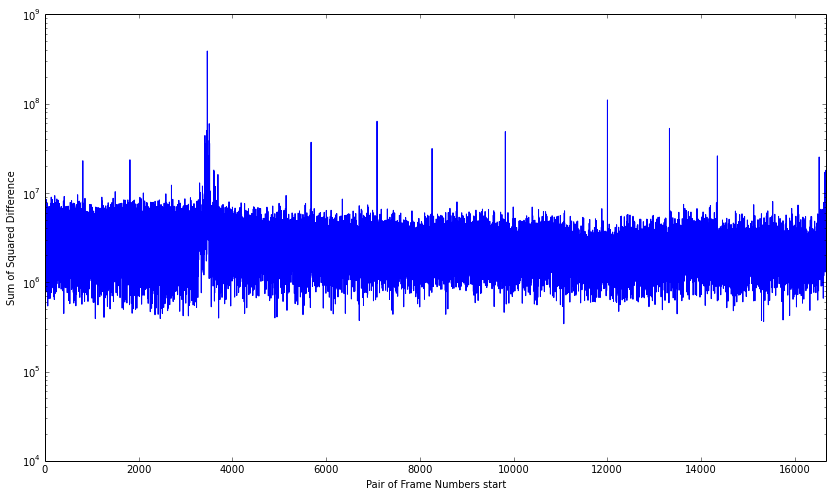

In [48]:
p = pd.Series(sqrdiff)
ax = p.plot(figsize=(14,8), logy=True)
ax.set_xlabel("Pair of Frame Numbers start")
_ = ax.set_ylabel("Sum of Squared Difference")

# Have pandas describe the interframe differences

In [7]:
p.describe()

count    1.666500e+04
mean     2.880734e+06
std      4.001345e+06
min      2.360800e+04
25%      1.822515e+06
50%      2.473952e+06
75%      3.338617e+06
max      3.890238e+08
dtype: float64

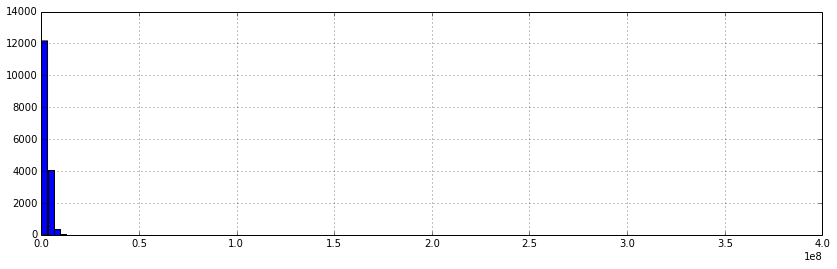

In [8]:
p.hist(bins=121, figsize=(14,4))

# Display the square of differences above

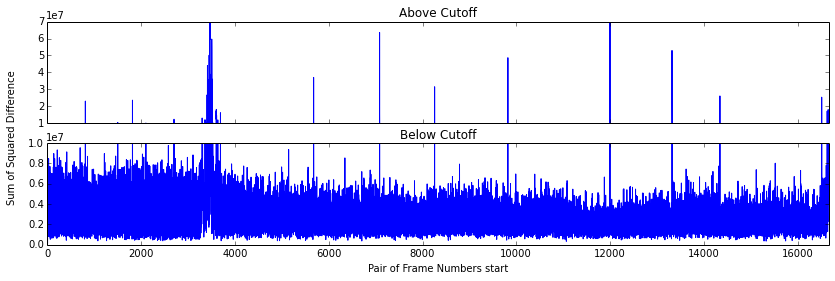

In [45]:
#display the square of differences above and below the cutoff
cutoff = p.quantile(0.994)
fig, axes = plt.subplots(sharex=True, nrows=2, ncols=1,
                         figsize=(14, 4))
p.plot(ylim=[cutoff, 0.7e8], title="Above Cutoff", ax=axes[0])
p.plot(ylim=[0, cutoff], title="Below Cutoff", ax=axes[1])
axes[1].set_xlabel("Pair of Frame Numbers start")
fig.text(0.09, 0.5, 'Sum of Squared Difference', 
         ha='center', va='center', rotation='vertical')

# List high change scenes
Add the end scenes to the list of scenes with high change

In [26]:
# Create a list of entries whose sum of square difference is above the cutoff
# add the first frame and last frame a scene boundaries
o = np.concatenate(([1], p[p>cutoff].index.values, [end]))
print(o)

[    1   807   808  1499  1813  2099  2699  3299  3308  3360  3403  3404
  3405  3412  3413  3414  3415  3424  3425  3426  3427  3428  3430  3435
  3436  3439  3440  3441  3447  3448  3462  3463  3464  3465  3466  3467
  3469  3470  3472  3476  3479  3480  3482  3483  3484  3486  3487  3488
  3489  3490  3493  3495  3496  3497  3498  3501  3504  3506  3507  3508
  3510  3511  3512  3520  3525  3596  3597  3598  3599  3600  3601  3602
  3603  3604  3605  3606  3607  3610  3611  3613  3633  3690  5677  7084
  7085  8257  8258  9820  9821 11999 13322 13323 14344 16515 16632 16649
 16653 16654 16656 16657 16660 16666]


# Get rid of noisy frame ranges
I found there was some scene zooming, we remove these frames by only including noisy scenes if they occur at least 90 frames after the last noisy scene

In [27]:
calmthresh = 90
calmderiv = list(ifilter(lambda x: x[1]-x[0] > calmthresh, window(o,2)))
print(calmderiv)

[(1, 807), (808, 1499), (1499, 1813), (1813, 2099), (2099, 2699), (2699, 3299), (3690, 5677), (5677, 7084), (7085, 8257), (8258, 9820), (9821, 11999), (11999, 13322), (13323, 14344), (14344, 16515), (16515, 16632)]


# Remove slide transitions
Slides had transitions, so trim 5 frames off of each scene border

In [28]:
border = 5
calm = map(lambda x: (x[0]+border,x[1]-border), calmderiv)
print calm

[(6, 802), (813, 1494), (1504, 1808), (1818, 2094), (2104, 2694), (2704, 3294), (3695, 5672), (5682, 7079), (7090, 8252), (8263, 9815), (9826, 11994), (12004, 13317), (13328, 14339), (14349, 16510), (16520, 16627)]


# Average each channel/pixel value for every frame in a scene

In [51]:
def scene_ave(scene_ranges, ysize = 480, xsize = 600, channels = 3):
    """
    return an image cube whith a layer for each range tuple in the
      scene_ranges list. And each pixel in that layer is the average of the
      corresponding pixels in each frame of the range.
    """
    scenes = len(scene_ranges)
    # create an image reading function
    im32 = t_imread(np.uint32)
    
    # Create a cube of images that has 1 image for each scene
    scube = np.ndarray((scenes, ysize*2, xsize*2, channels), dtype='uint8')
    for s, (x,y) in enumerate(scene_ranges):
        # create a temporary image cube for all the frames in a scene
        cube = np.ndarray((y-x, ysize, xsize, channels), dtype='uint8')
        for i in xrange(x, y):
            cube[i-x,:,:,:] = im32(fname(i))
        # average the channels across the appropriate dimension
        ave = cube.mean(axis=0).round().astype(np.uint8)
        # resize the image for display
        scube[s] = cv2.resize(ave, (2*xsize, 2*ysize))
    return scube
%time scube = scene_ave(calm)

CPU times: user 2min 12s, sys: 38.8 s, total: 2min 51s
Wall time: 2min 53s


# Some more cleanup functions to apply
* UnsharpMask
* AutoLevel

In [14]:
def showbgr(img, title=None):
    """
    Display the opencv image appropriately.
    """
    if title:
        plt.title(title)
    return plt.imshow(cv2.cvtColor(img, cv2.cv.CV_BGR2RGB))

def unsharpMask(img, alpha=3.5, beta=-2.5, gamma=.5,
                ksize=(11,11), sigmaX=0, sigmaY=0):
    """
    Return the image with the appropriate unsharp mask applied.
    
    XXX: Need to document the book that taught me this.
    """
    # Gausian Blur the image
    imgblur = cv2.GaussianBlur(img, ksize, sigmaX, sigmaY)
    # subtract a multiple of the blurred image from an amplified original
    return cv2.addWeighted(img, alpha, imgblur, beta, gamma)

def autoLevel(img):
    """
    Return the image normalized to the brightest and darkest pixel
    out of all the channels.
    """
    i = img.astype(np.double)
    return ((i-i.min())*255/(i.max())).astype(np.uint8)


# Display the detected, sharpened, leveled images

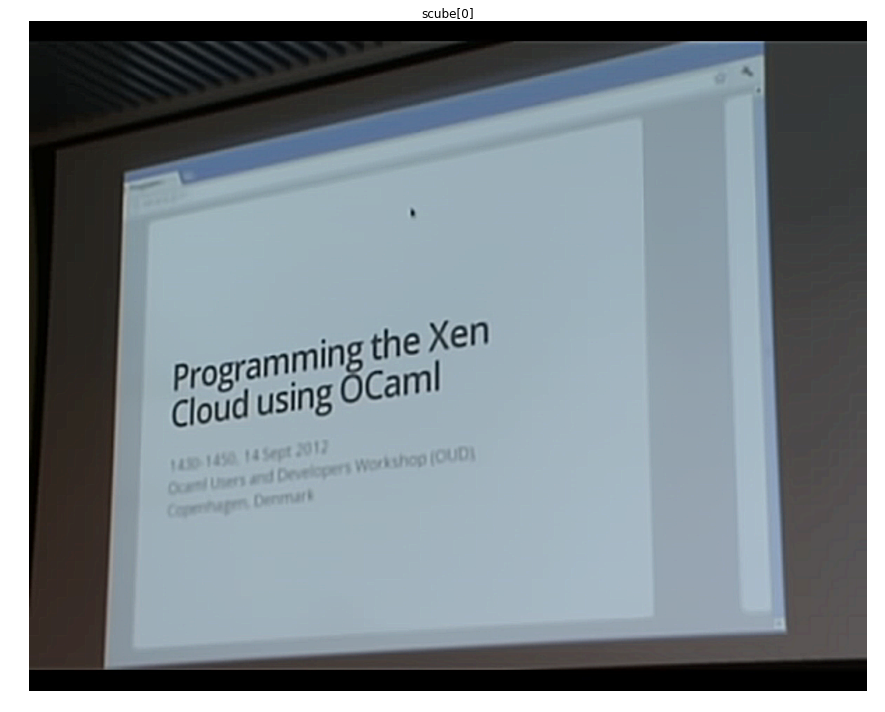

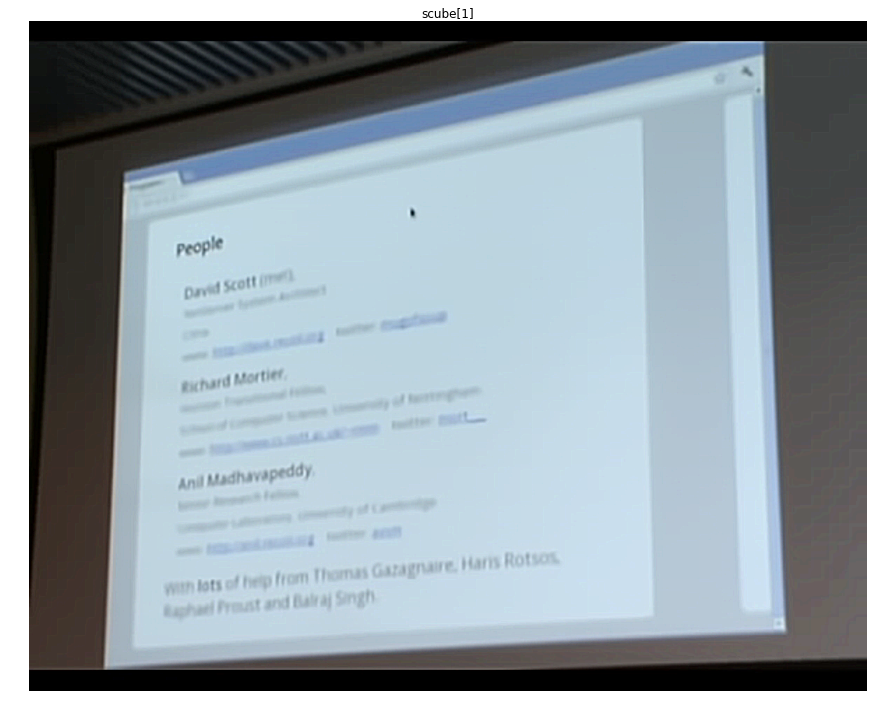

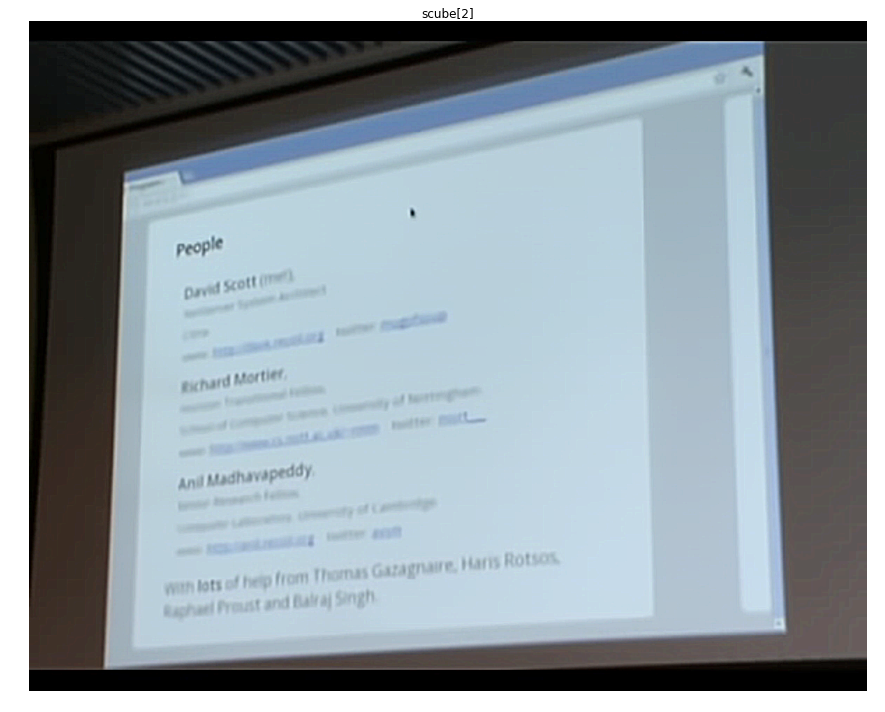

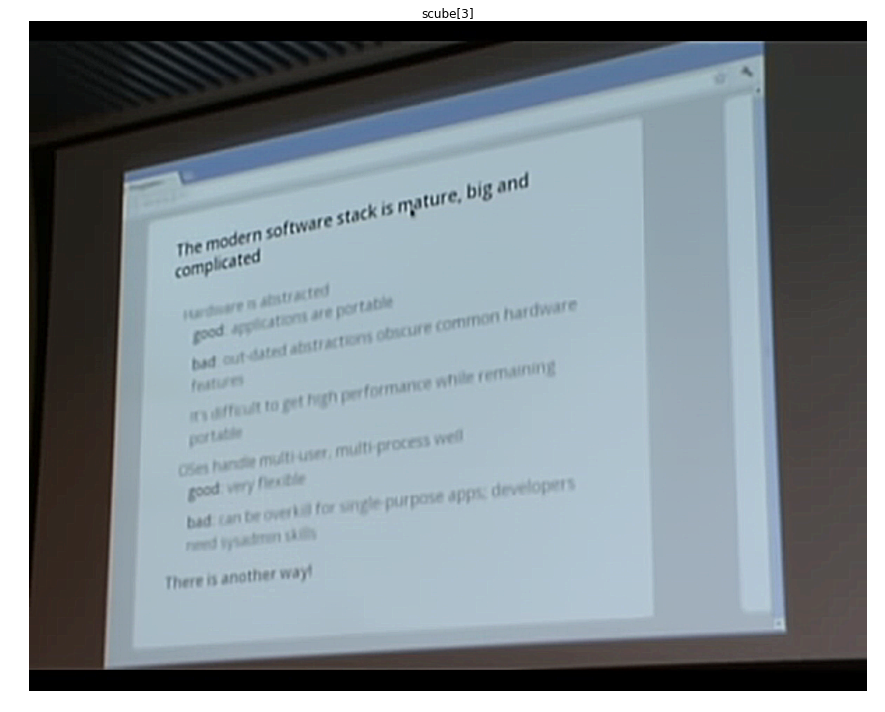

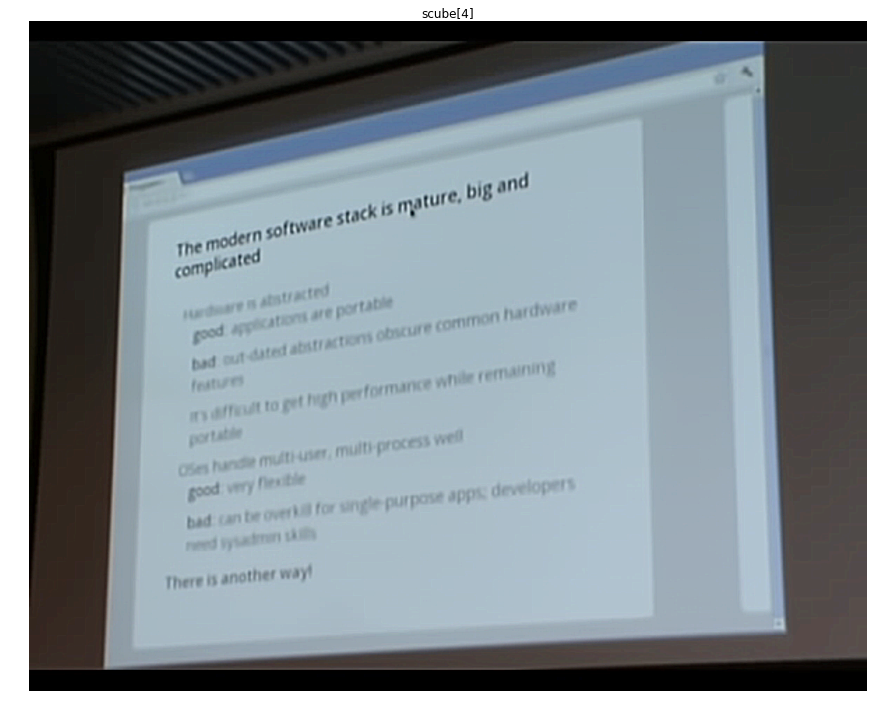

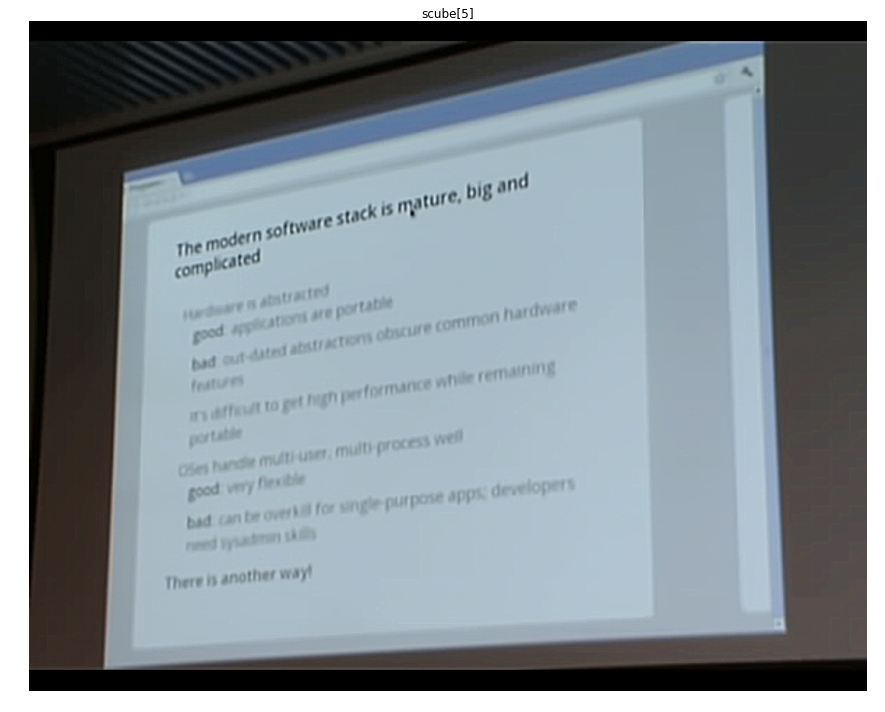

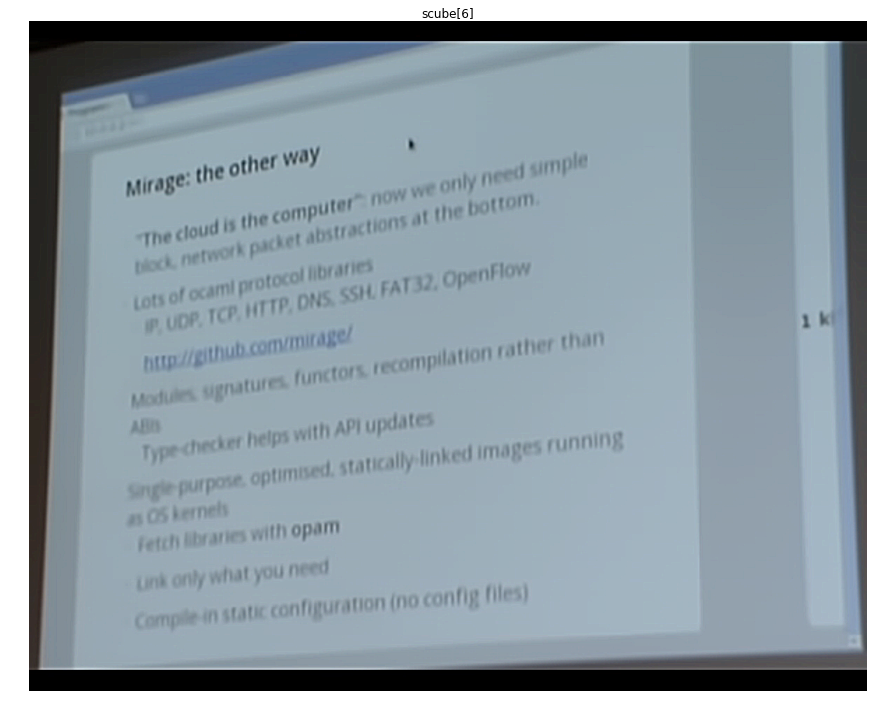

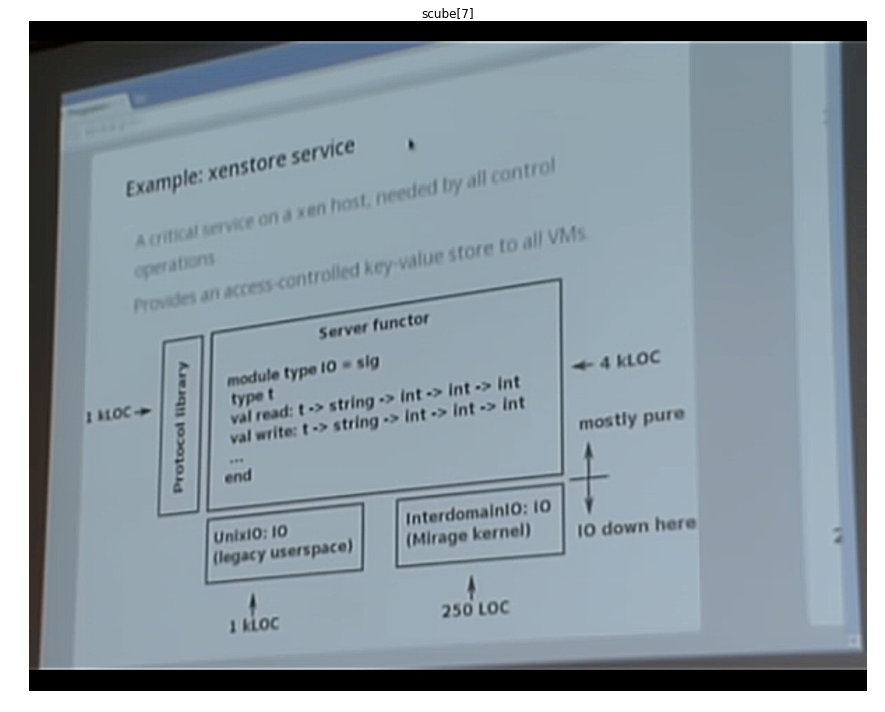

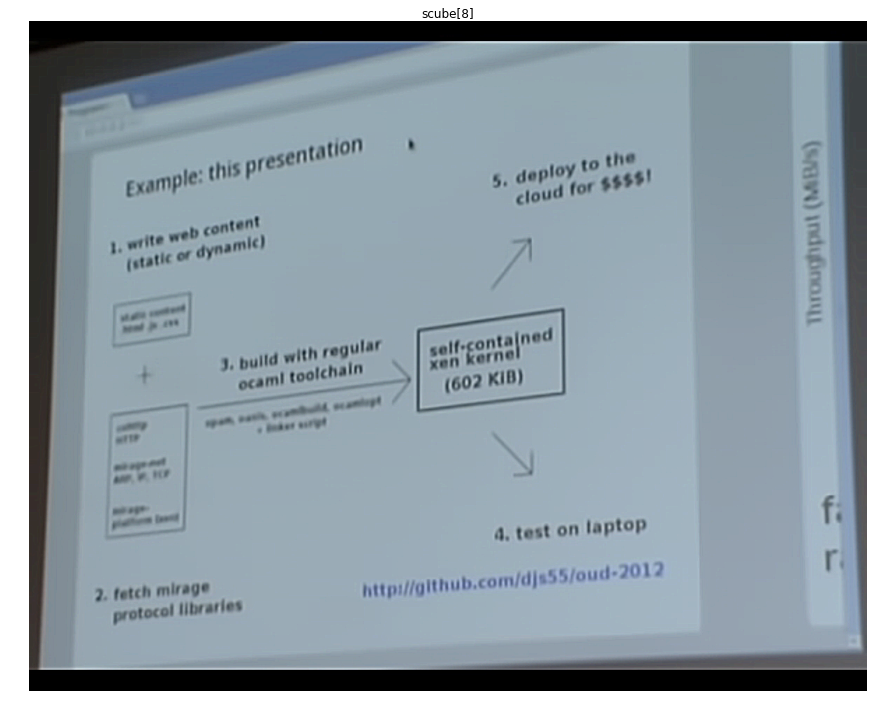

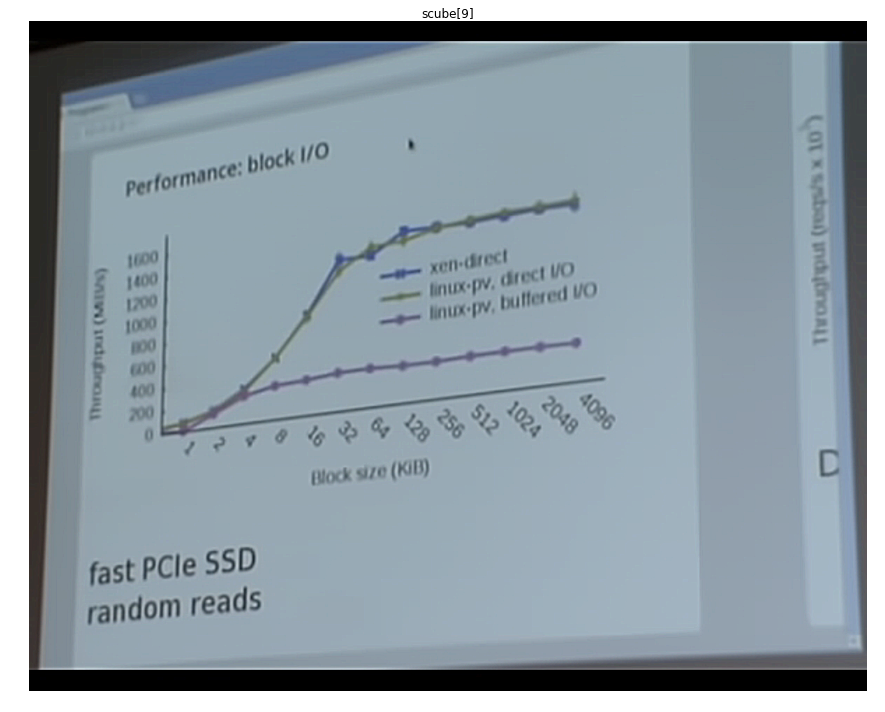

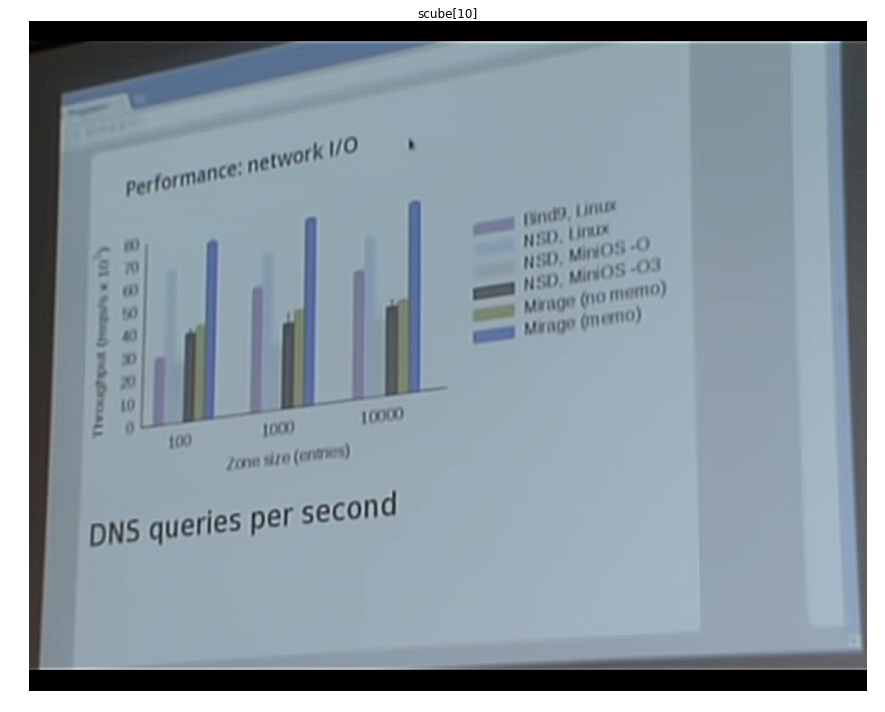

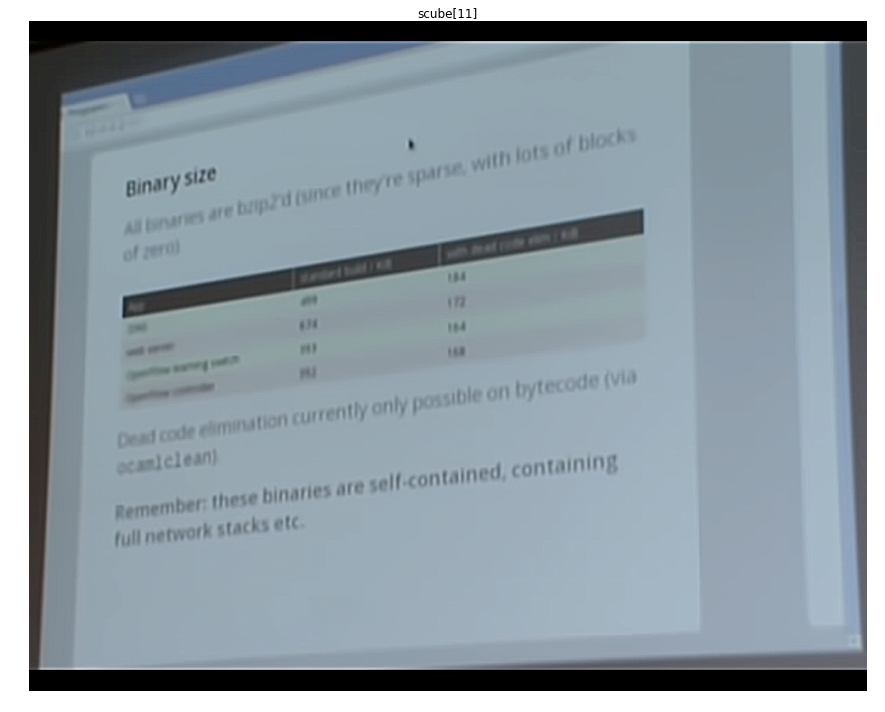

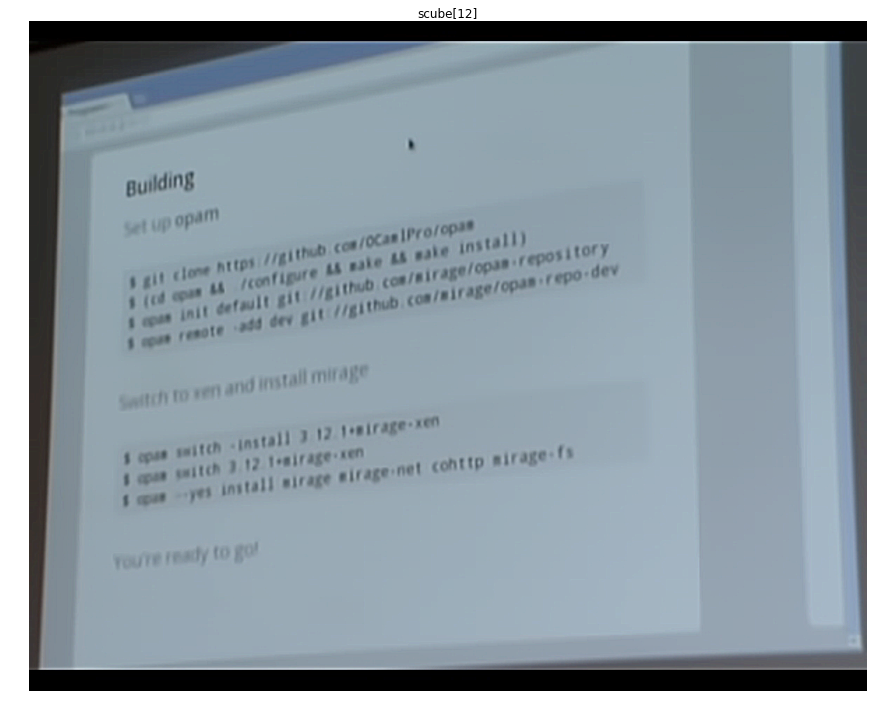

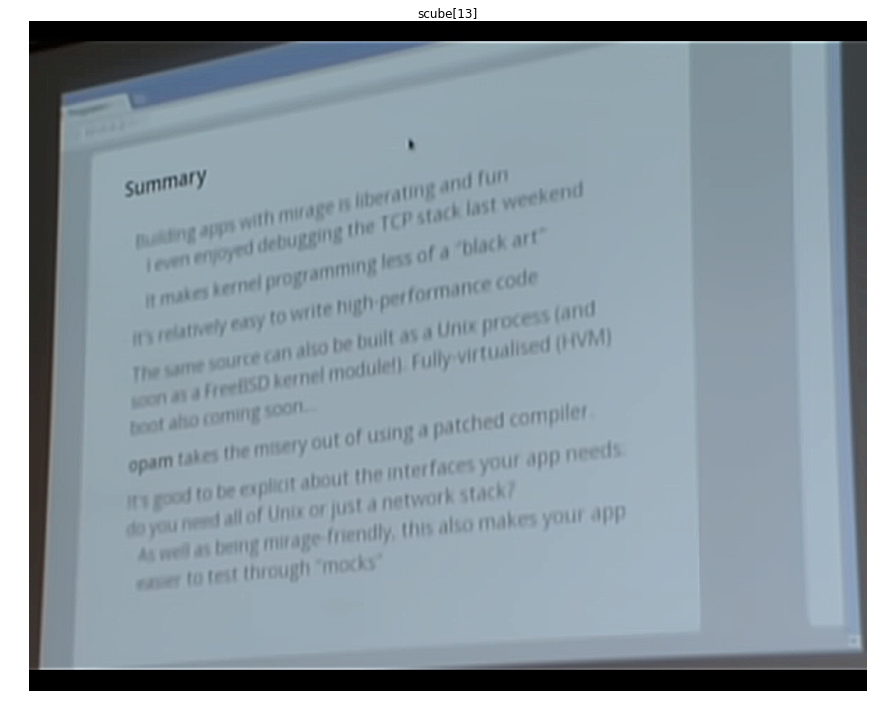

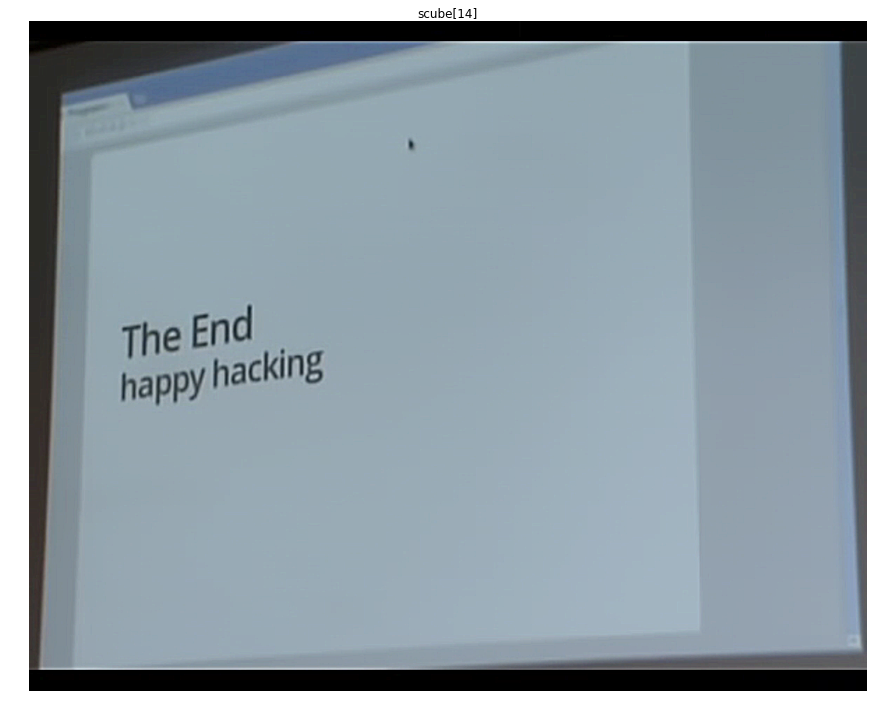

In [52]:
for ind, img in enumerate(scube):
    plt.figure()
    ax = showbgr(autoLevel(unsharpMask(img)), "scube[" + str(ind) + "]")
    ax.get_axes().axis('off')

   #Thanks